In [38]:
from dpks.quant_matrix import QuantMatrix
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, HDBSCAN

import pandas as pd
import numpy as np
import seaborn as sns

In [39]:
design_matrix = pd.read_csv(
    "../tests/input_files/design_sepsis.tsv",
    #"/home/aaron/projects/dpks/notebooks/ml_api/covid_design_matrix.tsv",
    sep="\t"
)

In [40]:
design_matrix = design_matrix.sort_values("group", ascending=False).reset_index(drop=True)
design_matrix

,sample,group
0,TM_P1911_190,2
1,TM_P1912_030,2
2,TM_P1912_032,2
3,TM_P1912_033,2
4,TM_P1912_034,2
...,...,...
192,TM_M2012_138,1
193,TM_M2012_046,1
194,TM_M2012_129,1
195,TM_M2012_128,1


In [41]:
design_matrix['group'].value_counts()

group
2    123
1     74
Name: count, dtype: int64

In [42]:
qm = QuantMatrix(
    #quantification_file="/home/aaron/projects/dpks/notebooks/ml_api/quantified_proteins.tsv", 
    quantification_file="../tests/input_files/data_sepsis.tsv",
    design_matrix_file=design_matrix
).filter().normalize(method="mean").quantify(method="top_n", top_n=3, summarization_method="mean").impute(method="uniform_percentile")

/srv/data1/home/aaron/projects/sepsis_alarm/notebooks/analysis/240701_alt/DPKS/dpks/quantification.py:94: RuntimeWarning: Mean of empty slice
  quantification: np.ndarray = np.nanmean(


In [43]:
qm = qm.compare(
    method="linregress",
    min_samples_per_group=10,
    comparisons=[(2, 1)]
)

In [44]:
X, y = qm.to_ml()

In [45]:
X

,P08603,P02671,P01042,P00450,P05156,P02452,P10643,B9A064,P02787,P00738,...,P01616,P17538,P55083,P08195,P18136,P07333,Q06323,P16035,O95633,O00194
TM_P1911_190,26.573443,30.414030,25.186033,27.074122,23.354331,25.008606,23.949753,28.820547,28.248075,32.259085,...,21.490898,14.018457,16.592616,16.558992,14.917392,16.002357,13.565721,14.535207,15.083107,13.944268
TM_P1912_030,27.083506,29.167885,25.495279,26.980717,22.145539,18.767536,23.104178,29.009921,28.572139,31.859478,...,21.999736,14.634187,13.605886,18.354746,20.666000,20.647897,15.115954,13.832264,15.636300,13.823989
TM_P1912_032,26.710508,30.201201,24.754007,26.575800,23.675778,25.708159,23.172960,28.372428,27.652258,31.378488,...,25.521041,13.379461,15.174940,15.470438,14.997016,14.695623,15.177222,14.254060,13.410719,13.855945
TM_P1912_033,27.076933,29.626100,25.381406,27.178537,22.901699,18.265912,23.237137,29.096738,29.065703,31.465902,...,21.794770,18.087066,13.597781,18.488034,19.326489,20.980876,15.378573,16.159955,13.901169,16.166757
TM_P1912_034,26.958747,29.407725,25.513667,27.046556,22.864036,16.991510,23.242471,29.072251,29.296427,31.450523,...,21.752500,18.851191,15.216104,16.154995,13.338581,20.382838,14.154409,15.336520,15.441338,13.284349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TM_M2012_138,25.606155,28.661465,26.275698,26.450327,23.163942,26.268418,22.790413,29.282766,28.947672,28.896758,...,22.248459,14.066663,14.167615,19.117308,13.783564,20.059113,20.598890,18.714571,13.643281,15.703190
TM_M2012_046,25.755329,30.276096,25.762032,26.503985,23.601898,13.919332,23.301275,26.555082,29.080204,31.591836,...,18.533788,19.981019,14.007468,16.560526,13.533584,15.909069,16.607141,13.412897,14.983574,15.593558
TM_M2012_129,25.693048,30.093610,25.711535,26.364655,23.505068,24.600329,23.195304,27.324822,28.467790,31.172964,...,21.671989,18.636890,14.173195,15.633353,16.433976,13.842131,15.913839,17.878274,16.344414,13.715898
TM_M2012_128,25.891135,30.090042,25.849126,26.521138,23.624856,25.302674,23.421284,27.219719,28.669361,31.215393,...,19.938109,19.070976,16.226923,15.172366,14.519236,15.597282,15.312387,14.731985,15.964389,15.049172


In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X[:] = scaler.fit_transform(X[:])

In [145]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Lasso, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost

# clf = xgboost.XGBClassifier(
#     #max_depth=10,
#     n_jobs=1,
#     #subsample=0.5,
#     #reg_lambda=2,
#     # objective="binary:logitraw",
#     # seed=42,
#     # eval_metric="logloss",
# )
# clf = HistGradientBoostingClassifier()
clf = LogisticRegression()
#clf = SVC(kernel="linear")
#clf = RandomForestClassifier()
#clf = Lasso()
#clf = AdaBoostClassifier()
#clf = SGDClassifier()

clf.fit(X.values, y.values.ravel())

LogisticRegression()

In [146]:
from sklearn.inspection import permutation_importance


importances = permutation_importance(
    clf,
    X.values,
    y.values.ravel(),
    scoring="neg_log_loss",
    n_jobs=1,
    #max_samples=0.5,
    n_repeats=1,
)

In [147]:
feature_importances = pd.DataFrame(
    {
        "feature": X.columns,
        "importance": importances['importances_mean']
    }
)

In [148]:
feature_importances.sort_values("importance", ascending=False)

,feature,importance
41,P06727,0.000741
425,P01880,0.000595
356,Q96PD5,0.000399
459,P80188,0.000346
175,P08185,0.000330
...,...,...
27,P34096,-0.000012
290,P27348,-0.000013
391,A6NL28,-0.000016
434,P01764,-0.000018


<Axes: xlabel='importance', ylabel='feature'>

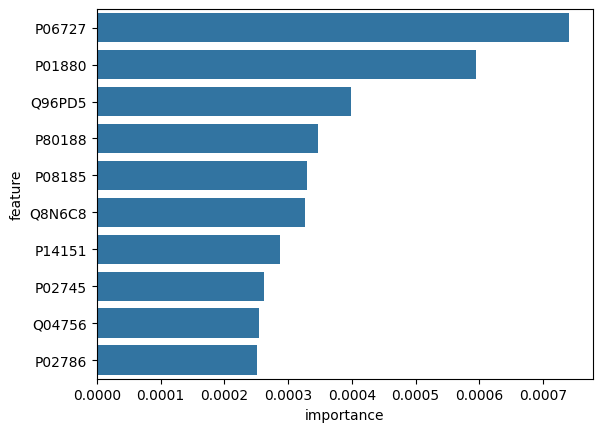

In [149]:
sns.barplot(x="importance", y="feature", data=feature_importances.sort_values("importance", ascending=False).head(10))

In [150]:
from dpks.interpretation import FeatureImportance

importance_calculator = FeatureImportance(
    n_iterations=10,
    feature_names=X.columns.values,
)

importance_calculator.fit(clf, X.values)

In [151]:
feature_importances['loss_importance'] = importance_calculator.global_explanations

<Axes: xlabel='loss_importance', ylabel='feature'>

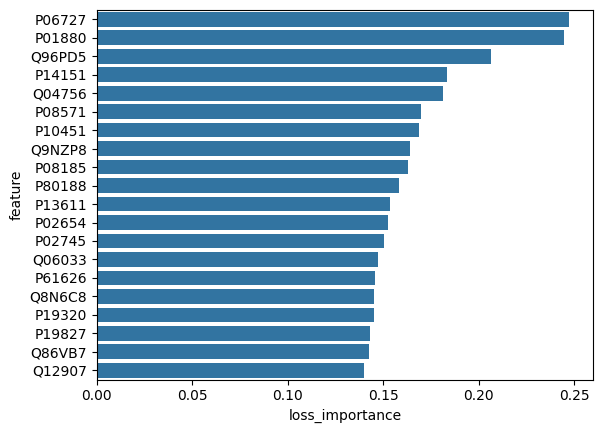

In [152]:
sns.barplot(
    data=feature_importances.sort_values("loss_importance", ascending=False).head(20),
    x="loss_importance",
    y="feature"
)

In [153]:
import shap

In [155]:
explainer = shap.LinearExplainer(clf, X)
#explainer = shap.TreeExplainer(clf)
#explainer = shap.Explainer(clf)
shap_values = explainer(X)

In [158]:
feature_importances['shap_importance'] = np.mean(abs(shap_values.values), axis=0)

In [159]:
feature_importances.sort_values("shap_importance", ascending=False)

,feature,importance,loss_importance,shap_importance
41,P06727,7.413314e-04,0.247526,0.236593
425,P01880,5.954660e-04,0.244762,0.227011
356,Q96PD5,3.985387e-04,0.206319,0.193552
395,P14151,2.869667e-04,0.183361,0.174767
39,Q04756,2.539041e-04,0.181156,0.170105
...,...,...,...,...
442,P04433,-2.828852e-07,0.000458,0.000417
288,P37802,1.636220e-07,0.000251,0.000248
504,P06889,2.092966e-08,0.000171,0.000165
255,O95497,-5.542846e-09,0.000108,0.000101


<Axes: xlabel='shap_importance', ylabel='feature'>

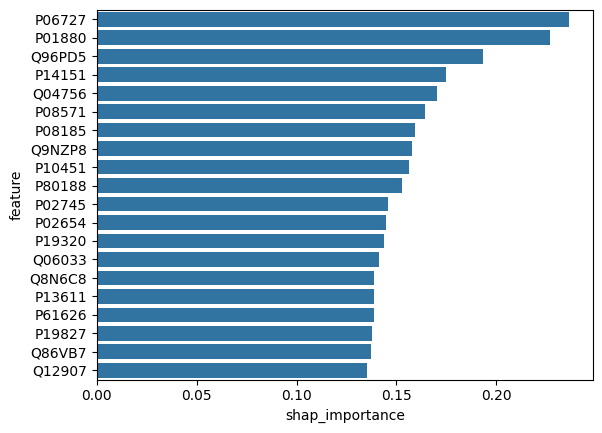

In [160]:
sns.barplot(
    data=feature_importances.sort_values("shap_importance", ascending=False).head(20),
    x="shap_importance",
    y="feature"
)

<Axes: xlabel='shap_importance', ylabel='loss_importance'>

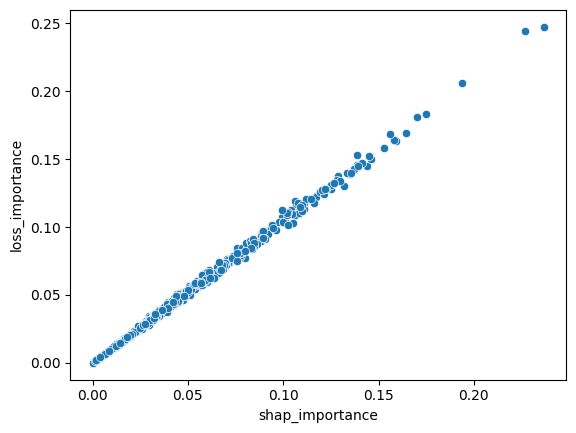

In [161]:
sns.scatterplot(
    data=feature_importances,
    x="shap_importance",
    y="loss_importance",
)

<Axes: xlabel='importance', ylabel='loss_importance'>

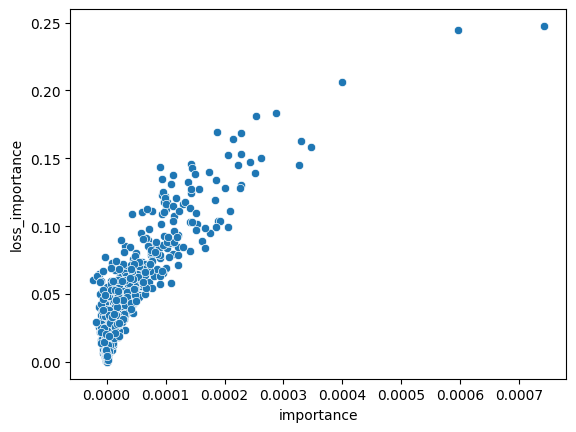

In [162]:
sns.scatterplot(
    data=feature_importances,
    x="importance",
    y="loss_importance",
)

<Axes: xlabel='importance', ylabel='shap_importance'>

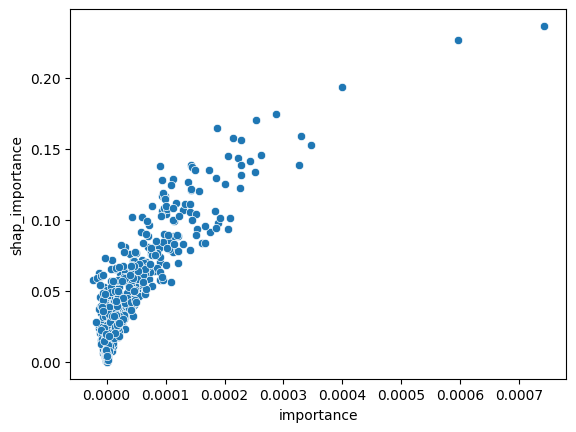

In [163]:
sns.scatterplot(
    data=feature_importances,
    x="importance",
    y="shap_importance",
)

In [180]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Lasso, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost

clf = xgboost.XGBClassifier(
    # max_depth=2,
    # #subsample=0.5,
    # reg_lambda=2,
    n_jobs=1,
    objective="binary:logistic",
    # seed=42,
    # eval_metric="logloss",
)
#clf = HistGradientBoostingClassifier()
#clf = LogisticRegression()
#clf = SVC(kernel="linear")
#clf = RandomForestClassifier()
#clf = Lasso()
#clf = AdaBoostClassifier()
#clf = SGDClassifier()

clf.fit(X.values, y.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=1,
              num_parallel_tree=None, random_state=None, ...)

In [181]:
from sklearn.inspection import permutation_importance


importances = permutation_importance(
    clf,
    X.values,
    y.values.ravel(),
    scoring="neg_log_loss",
    n_jobs=1,
    #max_samples=0.5,
    n_repeats=1,
)

In [182]:
xgb_feature_importances = pd.DataFrame(
    {
        "feature": X.columns,
        "importance": importances['importances_mean']
    }
)

<Axes: xlabel='importance', ylabel='feature'>

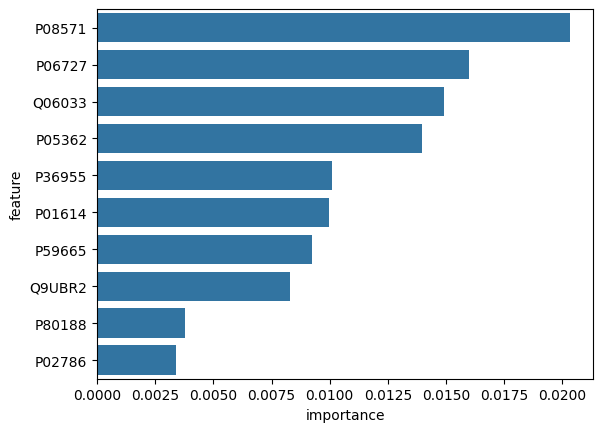

In [183]:
sns.barplot(x="importance", y="feature", data=xgb_feature_importances.sort_values("importance", ascending=False).head(10))

In [184]:
from dpks.interpretation import FeatureImportance

importance_calculator = FeatureImportance(
    n_iterations=3,
    feature_names=X.columns.values,
)

importance_calculator.fit(clf, X.values)

In [185]:
xgb_feature_importances['loss_importance'] = importance_calculator.global_explanations

In [186]:
xgb_feature_importances.sort_values("loss_importance", ascending=False)

,feature,importance,loss_importance
147,P08571,0.020310,0.020016
41,P06727,0.016002,0.014656
78,P05362,0.013966,0.013449
338,Q06033,0.014921,0.013225
114,P36955,0.010118,0.010656
...,...,...,...
188,P01860,0.000000,0.000000
187,P15311,0.000000,0.000000
185,P43121,0.000000,0.000000
184,P11021,0.000000,0.000000


<Axes: xlabel='loss_importance', ylabel='feature'>

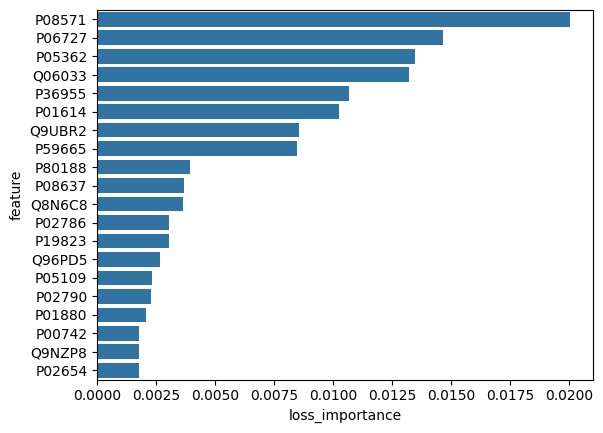

In [187]:
sns.barplot(
    data=xgb_feature_importances.sort_values("loss_importance", ascending=False).head(20),
    x="loss_importance",
    y="feature"
)

In [188]:
import shap

In [189]:
#explainer = shap.LinearExplainer(clf, X)
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X)

In [190]:
feature_importances['shap_importance'] = np.mean(abs(shap_values.values), axis=0)

In [191]:
feature_importances.sort_values("shap_importance", ascending=False)

,feature,importance,loss_importance,shap_importance
147,P08571,1.874510e-04,0.169638,0.817003
41,P06727,7.413314e-04,0.247526,0.620100
78,P05362,9.350842e-05,0.122764,0.577860
114,P36955,9.798765e-05,0.118037,0.506454
231,P59665,9.675924e-05,0.110227,0.427837
...,...,...,...,...
188,P01860,-2.767601e-07,0.000662,0.000000
187,P15311,8.004972e-08,0.013816,0.000000
185,P43121,1.086349e-04,0.058424,0.000000
184,P11021,1.247490e-06,0.010979,0.000000


<Axes: xlabel='shap_importance', ylabel='feature'>

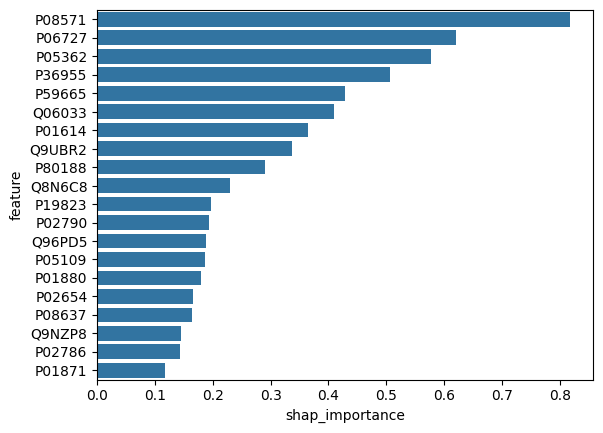

In [192]:
sns.barplot(
    data=feature_importances.sort_values("shap_importance", ascending=False).head(20),
    x="shap_importance",
    y="feature"
)

In [193]:
explanations = pd.DataFrame(
    importance_calculator.local_explanations.T,
    columns=list(X.columns.values),
    index=list(X.index.values)
)

In [194]:
explanations = explanations.join(y)

In [195]:
explanations_melted = explanations.reset_index(names="Sample").melt(
    id_vars=["Sample", "label"]
)

In [196]:
feature_importances.sort_values("loss_importance", ascending=False)

,feature,importance,loss_importance,shap_importance
41,P06727,7.413314e-04,0.247526,0.620100
425,P01880,5.954660e-04,0.244762,0.179871
356,Q96PD5,3.985387e-04,0.206319,0.188563
395,P14151,2.869667e-04,0.183361,0.000000
39,Q04756,2.539041e-04,0.181156,0.099189
...,...,...,...,...
442,P04433,-2.828852e-07,0.000458,0.000000
288,P37802,1.636220e-07,0.000251,0.000000
504,P06889,2.092966e-08,0.000171,0.000000
255,O95497,-5.542846e-09,0.000108,0.000000


In [197]:
explanations_melted

,Sample,label,variable,value
0,TM_P1911_190,1,P08603,0.0
1,TM_P1912_030,1,P08603,0.0
2,TM_P1912_032,1,P08603,0.0
3,TM_P1912_033,1,P08603,0.0
4,TM_P1912_034,1,P08603,0.0
...,...,...,...,...
109133,TM_M2012_138,0,O00194,0.0
109134,TM_M2012_046,0,O00194,0.0
109135,TM_M2012_129,0,O00194,0.0
109136,TM_M2012_128,0,O00194,0.0


In [198]:
explanations_melted['mean'] = explanations_melted.groupby("variable")['value'].transform(lambda x: np.mean(np.abs(x)))

In [199]:
explanations_melted = explanations_melted.sort_values("mean", ascending=False)

In [200]:
explanations_melted = explanations_melted[explanations_melted['variable'].isin(explanations_melted['variable'].unique()[:10])]

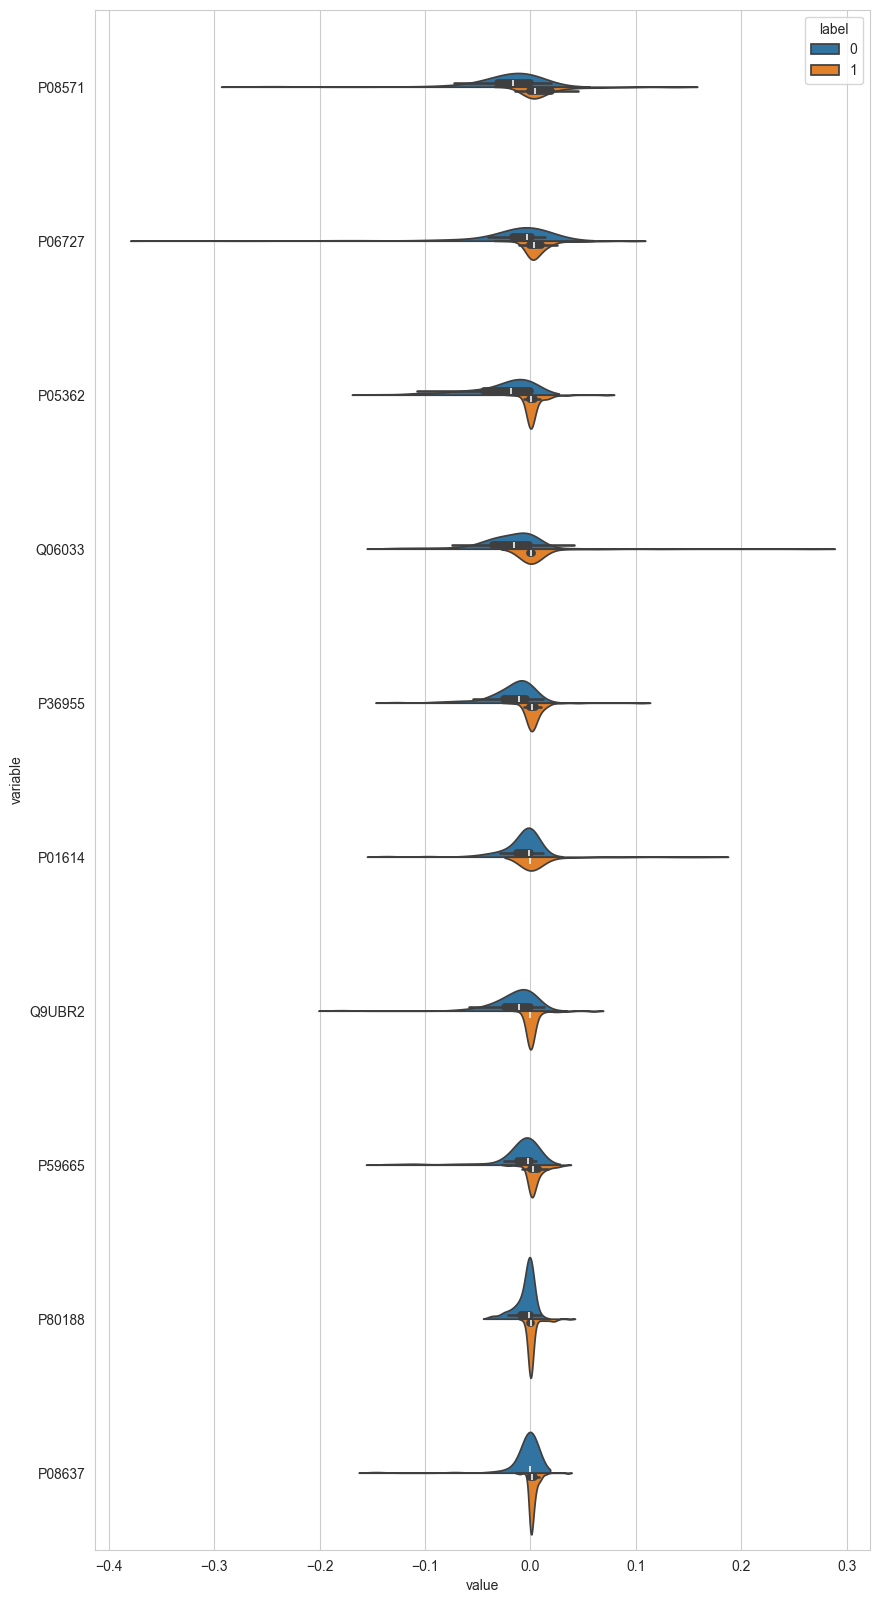

In [201]:
sns.set_style("whitegrid")

ax = sns.violinplot(
    data=explanations_melted,
    x="value",
    y="variable",
    hue="label",
    split=True
)

ax.figure.set_size_inches((10, 20))

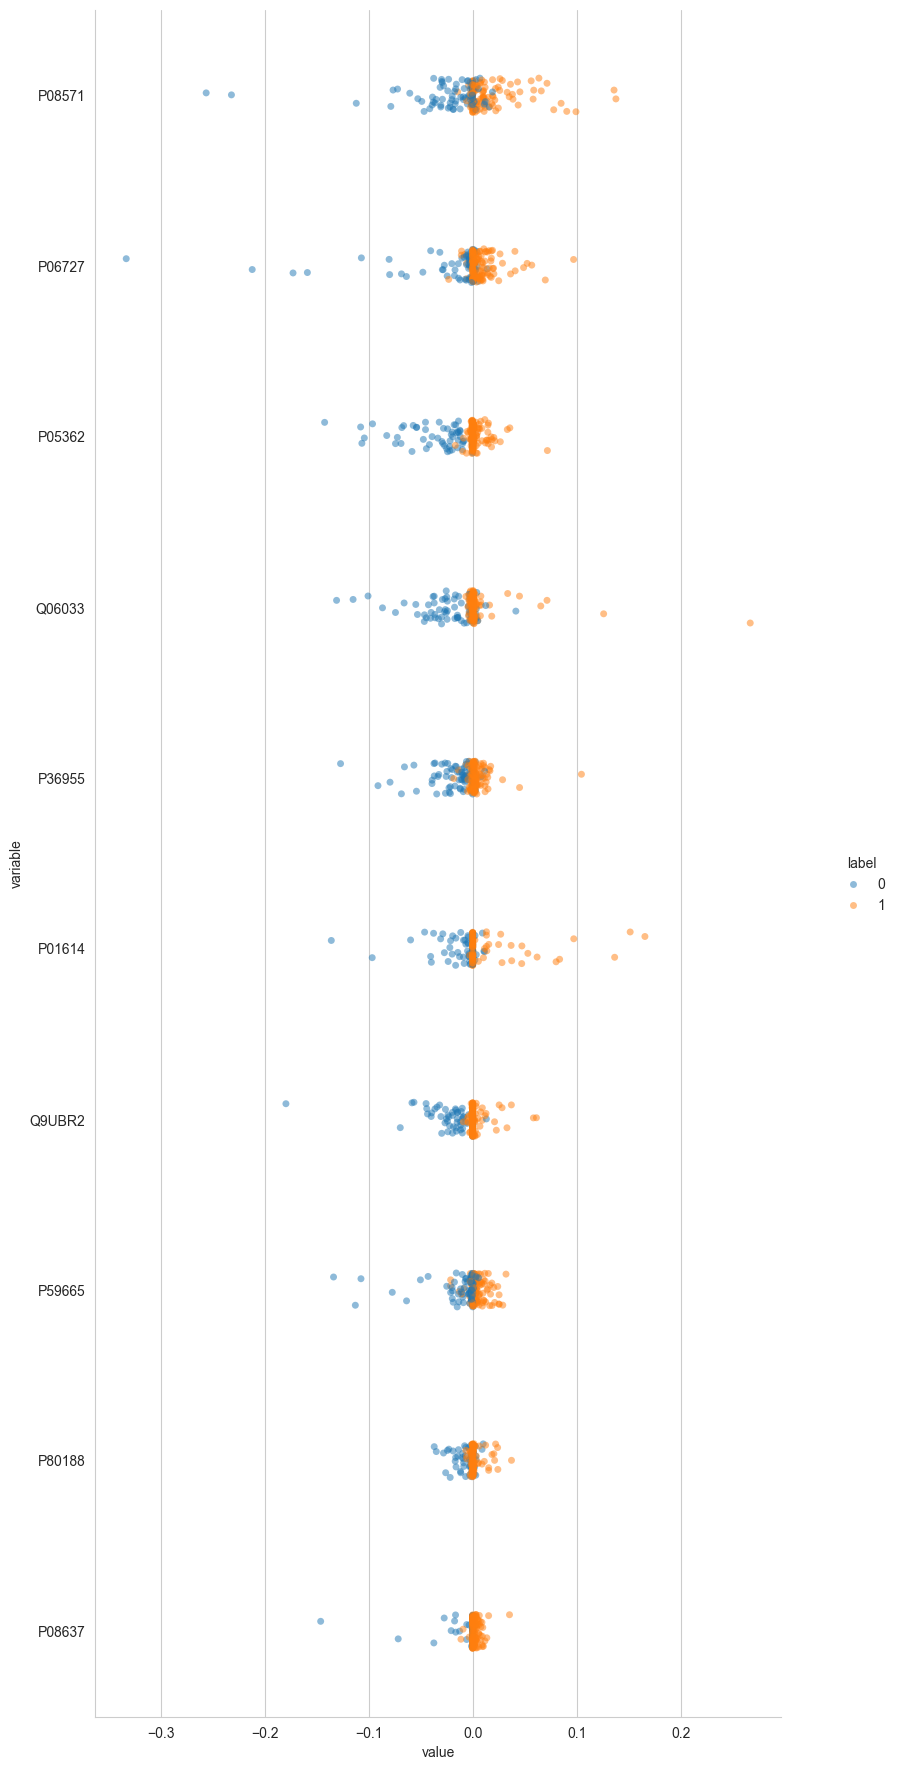

In [202]:
import matplotlib.pyplot as plt


# Show each observation with a scatterplot
ax = sns.catplot(data=explanations_melted, x="value", y="variable", hue="label", alpha=0.5)

ax.figure.set_size_inches((10, 20))
